# DDPG Algorithm for Continuous Mountain Car-v0 environment¶

### 1. Import required libraries for the algorithm and its execution

In [1]:
import random
from collections import deque, namedtuple

import numpy as np
import gym
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F

### 2. Define neural network structure for both Actor and Critic networks

#### Class for the Critic network

In [2]:
class DDPGCritic(nn.Module):

    def __init__(self, state_size, action_size, layer_size):
        """
        Critic Network to be used in the DDPG algorithm.
        """
        super(DDPGCritic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.device = torch.device('cpu')

        # Define the NN input layer
        self.input_layer = nn.Linear(in_features=self.state_size, out_features=layer_size)
        # Define the second NN hidden layer
        self.hidden_layer1 = nn.Linear(in_features=layer_size, out_features=layer_size)
        # Define the output layer
        self.output_layer = nn.Linear(in_features=layer_size, out_features=self.action_size)

    def forward(self, state, action = None):
        """
        Forward propagation.
        """
        # FEED INPUT DATA TO THE NEURAL NETWORK
        x = torch.cat([state, action], 1)

        # Feed the input to the INPUT_LAYER and apply ReLu activation function
        x = torch.relu(self.input_layer(x))
        # Feed the output of INPUT_LAYER to the HIDDEN_LAYER layer and apply ReLu activation function
        x = torch.relu(self.hidden_layer1(x))
        # Feed the output of HIDDEN_LAYER to the output layer and apply tanh activation function
        return self.output_layer(x)

#### Class for the Actor network

In [3]:
class DDPGActor(nn.Module):

    def __init__(self, state_size, action_size, layer_size):
        """
        Actor Network to be used in the DDPG algorithm.
        """
        super(DDPGActor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.device = torch.device('cpu')

        # Define the NN input layer
        self.input_layer = nn.Linear(in_features=self.state_size, out_features=layer_size)
        # Define the second NN hidden layer
        self.hidden_layer1 = nn.Linear(in_features=layer_size, out_features=layer_size)
        # Define the output layer
        self.output_layer = nn.Linear(in_features=layer_size, out_features=self.action_size)

    def forward(self, state):
        """
        Forward propagation.
        """
        # FEED INPUT DATA TO THE NEURAL NETWORK
        # Feed the input to the INPUT_LAYER and apply ReLu activation function
        x = torch.relu(self.input_layer(state))
        # Feed the output of INPUT_LAYER to the HIDDEN_LAYER layer and apply ReLu activation function
        x = torch.relu(self.hidden_layer1(x))
        # Feed the output of HIDDEN_LAYER to the output layer and apply tanh activation function
        return torch.tanh(self.output_layer(x))

### 3. Define ReplayBuffer to store experiences and learn from them 

In [4]:
class ReplayBuffer:

    def __init__(self, buffer_size, batch_size):
        """
        Buffer to store experience tuples. Each experience has the following structure:
        (state, action, reward, next_state, done)
        """
        self.device = torch.device('cpu')
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """
        Add a new experience to the Replay Buffer.
        """
        # Create namedtuple object from the experience
        exp = self.experience(state, action, reward, next_state, done)
        # Add the experience object to memory
        self.memory.append(exp)

    def sample(self):
        """
        Randomly sample a batch of experiences from memory.
        """
        # Randomly sample a batch of experiences
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(
            np.stack([e.state if not isinstance(e.state, tuple) else e.state[0] for e in experiences])).float().to(
            self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(
            self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            self.device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """
        Return the current size of the Replay Buffer
        """
        return len(self.memory)

### 4. Define Ornstein-Uhlenbeck Noise process

*The code for the OU Noise process is extracted from https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py*

In [5]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu = mu
        self.theta = theta
        self.sigma = max_sigma
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
        self.action_dim = action_space.shape[0]
        self.low = action_space.low
        self.high = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t = 0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

### 5. Define the DDPG Agent class

This class will contain the logic related to the DDPG algorithm, where the previously defined components (Actor and Critic neural networks, Replay Buffer and OU Noise process) will interact.

In [6]:
class DDPGAgent:

    def __init__(self, environment, layer_size, actor_lr, critic_lr, gamma, tau, memory_size, batch_size):
        # Set parameters
        self.action_size = environment.action_space.shape[0]
        self.state_size = environment.observation_space.shape[0]
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        # Initialize Actor, Critic, Actor Target and Critic Target networks
        self.actor = DDPGActor(state_size=self.state_size, action_size=self.action_size,
                               layer_size=layer_size)
        self.actor_target = DDPGActor(state_size=self.state_size, action_size=self.action_size,
                                      layer_size=layer_size)
        self.critic = DDPGCritic(state_size=self.state_size + self.action_size, action_size=self.action_size,
                                 layer_size=layer_size)
        self.critic_target = DDPGCritic(state_size=self.state_size + self.action_size, action_size=self.action_size,
                                        layer_size=layer_size)

        # Copy weights of actor and critic nn into target nns
        for actor_w, actor_target_w, critic_w, critic_target_w in zip(self.actor.parameters(),
                                                                      self.actor_target.parameters(),
                                                                      self.critic.parameters(),
                                                                      self.critic_target.parameters()):
            actor_target_w.data.copy_(actor_w.data)
            critic_target_w.data.copy_(critic_w.data)

        # Initialize Optimizers
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        # Initialize Replay Buffer
        self.memory = ReplayBuffer(memory_size, self.batch_size)

    def step(self, state, action, reward, next_state, done):
        # Save experience in Replay Buffer
        self.memory.add(state, action, reward, next_state, done)

        # Perform learning if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            # Pick random batch of experiences
            experiences = self.memory.sample()
            # Learn from experiences
            self.learn(experiences)

    def act(self, state):
        state = torch.from_numpy(state)
        return self.actor(state).cpu().detach().numpy()

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Critic Loss
        q_values = self.critic(states, actions)
        next_actions = self.actor_target(next_states)
        q_next = self.critic_target(next_states, next_actions)
        q_prime = rewards + self.gamma * q_next
        critic_loss = F.mse_loss(q_values, q_prime)

        # Actor Loss
        policy_loss = -self.critic(states, self.actor(states)).mean()

        # Update Networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Soft Update the target networks
        self.soft_update()

    def soft_update(self):
        # Copy weights of actor and critic nn into target nns
        for actor_w, actor_target_w, critic_w, critic_target_w in zip(self.actor.parameters(),
                                                                      self.actor_target.parameters(),
                                                                      self.critic.parameters(),
                                                                      self.critic_target.parameters()):
            actor_target_w.data.copy_(self.tau * actor_w.data + (1. - self.tau) * actor_target_w.data)
            critic_target_w.data.copy_(self.tau * critic_w.data + (1. - self.tau) * critic_target_w.data)


### 6. Implement DDPG algorithm's flow

Episode: 1, Reward: 83.63, Average Reward: 83.63008720219398 

Episode: 2, Reward: -20.86, Average Reward: 31.385453001164855 

Episode: 3, Reward: -14.78, Average Reward: 15.995814215397493 

Episode: 4, Reward: -20.59, Average Reward: 6.849396655086461 

Episode: 5, Reward: -17.04, Average Reward: 2.0721432762010066 

Episode: 6, Reward: -18.86, Average Reward: -1.4157436801994177 

Episode: 7, Reward: -20.61, Average Reward: -4.158195715969855 

Episode: 8, Reward: -24.7, Average Reward: -6.7261651489204874 

Episode: 9, Reward: -22.28, Average Reward: -8.454325227775437 

Episode: 10, Reward: -21.8, Average Reward: -9.789335806224516 

Episode: 11, Reward: -19.35, Average Reward: -20.08726036422824 

Episode: 12, Reward: -23.95, Average Reward: -20.39591032465239 

Episode: 13, Reward: 81.25, Average Reward: -10.79268586853433 

Episode: 14, Reward: 84.76, Average Reward: -0.2572411158798914 

Episode: 15, Reward: -35.43, Average Reward: -2.09691703602 

Episode: 16, Reward: 68.21,

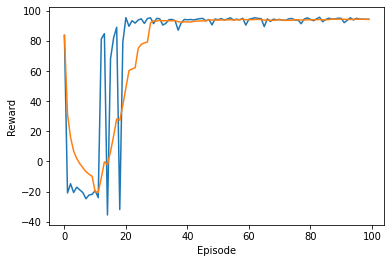

In [7]:
n_episodes = 100
n_timesteps = 500

# Initialize Gym environment
env = gym.make('MountainCarContinuous-v0')

# Initialize DDPG Agent
agent = DDPGAgent(environment=env,
                  layer_size=256,
                  actor_lr=0.0001,
                  critic_lr=0.001,
                  gamma=0.99,
                  tau=0.01,
                  memory_size=100000,
                  batch_size=128)
noise = OUNoise(env.action_space)
rewards, avg_rewards = list(), list()

for episode in range(n_episodes):
    state, _ = env.reset()
    noise.reset()
    ep_reward = 0

    for step in range(n_timesteps):

        action = agent.act(state)
        action = noise.get_action(action, step)
        next_state, reward, done, _, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)

        state = next_state
        ep_reward += reward

        if done:
            break
    rewards.append(ep_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

    print("Episode: {}, Reward: {}, Average Reward: {} \n".format(episode + 1,
                                                                  np.round(ep_reward, decimals=2),
                                                                  np.mean(rewards[-10:])))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

### 7. Evaluate trained agent

In [8]:
from IPython import display
%matplotlib inline

Episode 1 terminated with Reward 93.4605796928852


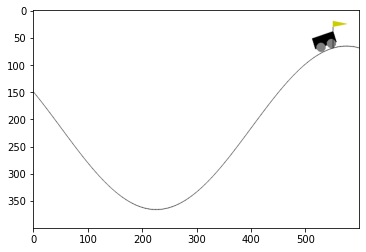

In [9]:
n_episodes = 1
n_timesteps = 500

# Initialize Gym environment
env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

rewards = list()

for episode in range(n_episodes):
    state, _ = env.reset()
    ep_reward = 0

    for step in range(n_timesteps):
        
        # Render testing episode
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)

        action = agent.actor(torch.from_numpy(state)).cpu().detach().numpy()
        next_state, reward, done, _, _ = env.step(action)

        state = next_state
        ep_reward += reward

        if done:
            break

    rewards.append(ep_reward)
    print(f'Episode {episode+1} terminated with Reward {ep_reward}')